# Gaussian Processes 2: Gaussian process regression

In the previous section we introduced stochsatic processes and defined the Gaussian process. In this section we'll demonstrate how Gaussian processes will allow us to solve regression tasks while naturally incorporating estimates of uncertainty.

---

Suppose we're given values of our function $f(\mathbf{x}_i) \in \mathbb{R}$ evaluated  at $n$ input points $\mathbf{x}_i \in \mathbb{R}^{d}$. We'll sometimes refer to this observed data as our _training data_. To simplify our notation, we'll use the matrix $X \in \mathbb{R}^{n \times d}$ to denote matrix of function input values for our training data, and we'll correspondingly use $\mathbf{f} \in \mathbb{R}^{n}$ to represent our training data's function outputs. Now let's assume that $f$ is drawn from a Gaussian process, i.e.,

$$f \sim \mathcal{GP}(\mathbf{0}, k(\mathbf{x}, \mathbf{x}'))$$

with the kernel $k$ chosen to reflect some prior belief about how the outputs of our function vary with respect to the input values. Our task now to predict the values of $f$ at a collection of test points $X_*$ for which we don't observe the corresponding outputs $\mathbf{f}_*$. Based on our Gaussian process asssumption, we have

$$
\begin{eqnarray}
\left[
    \begin{array}{l}
    \ \mathbf{f} \\ 
    \ \mathbf{f_*}
    \end{array}
 \right]
\end{eqnarray} \sim \mathcal{N}\left(\boldsymbol{0}, \begin{bmatrix} K(X, X) & K(X, X_*) \\ K(X_*, X) & K(X_*, X_*)\end{bmatrix}\right)$$ 

where $K(X,X)$ denotes the $n \times n$ matrix where the $(i, j)$'th entry corresponds to our kernel function evaluated at the training
inputs $\mathbf{x}_i$ and $\mathbf{x}_j$ (i.e., $k(\mathbf{x}_i, \mathbf{x}_j)$). We define $K(X, X_*)$, $K(X_*, X)$, and $K(X_*, X_*)$ 
analogously for pairs of training and/or test inputs. From the conditioning property of Gaussians, we then immediately obtain:

$$\mathbf{f_*} \mid X_*, X, \mathbf{f} \sim \mathcal{N}(K(X_*, X)K(X, X)^{-1}\mathbf{f}, K(X_*, X_*) - K(X_*, X)K(X, X)^{-1}K(X, X_*))$$

We can then sample function values $\mathbf{f_*}$ corresponding to our test inputs $X_*$ by sampling from the above distribution, and this procedure is known as _Gaussian process regression_. We'll make this procedure more concrete by illustrating it on a toy problem. Suppose we have
data generated from an underlying sine function

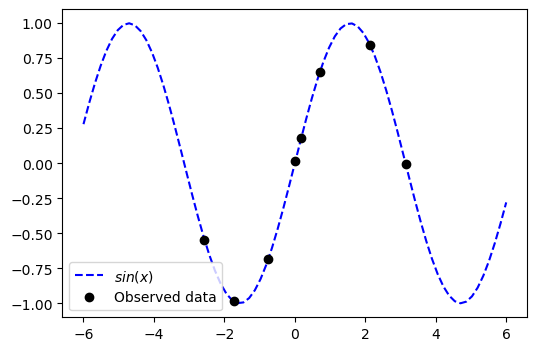

In [1]:
import numpy as np
import matplotlib.pyplot as plt

f_sin = lambda x: (np.sin(x)).flatten()

n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
x_train = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
y_train = f_sin(x_train)

# Predict points at uniform spacing to capture function
x_test = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(x_test, f_sin(x_test), 'b--', label='$sin(x)$')
ax.plot(x_train, y_train, 'ko', linewidth=2, label='Observed data')
ax.legend()
plt.show()

where the black dots are our observed data points and the dashed blue curve is our full underlying function. We can then apply GP regression to obtain predictions for values at unseen inputs. For a covariance function, we'll use the squared exponential kernel, which assumes that our functions outputs should be similar for input values that are close together.

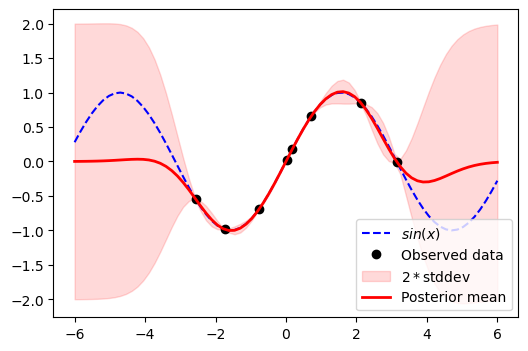

In [2]:
import scipy

def exponentiated_quadratic_kernel(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

# Gaussian process posterior
def GP(x_train, y_train, x_test, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    K = kernel_func(x_train, x_train)
    L = np.linalg.cholesky(K)
    m = np.linalg.solve(L, y_train)
    alpha = np.linalg.solve(L.T, m)

    # Kernel of observations vs to-predict
    K_s = kernel_func(x_train, x_test)
    mu = K_s.T @ alpha

    beta = np.linalg.solve(K, K_s)

    K_ss = kernel_func(x_test, x_test)
    cov = K_ss - K_s.T @ beta

    return mu, cov

# Compute posterior mean and covariance
mu_test, cov_test = GP(x_train, y_train, x_test, exponentiated_quadratic_kernel)
# Compute the standard deviation at the test points to be plotted
sigma_test = np.sqrt(np.diag(cov_test))

# Draw some samples of the posterior
y_test = np.random.multivariate_normal(mean=mu_test, cov=cov_test, size=ny)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(x_test, f_sin(x_test), 'b--', label='$sin(x)$')
ax.plot(x_train, y_train, 'ko', linewidth=2, label='Observed data')
ax.fill_between(x_test.flat, mu_test-2*sigma_test, mu_test+2*sigma_test, color='red', alpha=0.15, label=r'$2*\text{stddev}$')
ax.plot(x_test, mu_test, 'r-', lw=2, label=r'Posterior mean')
ax.legend()
plt.show()

where the solid red line denotes our posterior mean (i.e., the center of our predicted function values at unknown points) and the shaded red area represents how uncertain we are about predictions at individual inputs (as captured by two times the posterior standard deviation). We find that our GP regression procedure fits the underlying function reasonable well, at least for areas of the input space where we have observed data. Moreover, for inputs where our model does not have nearby observed data points and thus fails to make accurate predictions, the posterior distribution has a large degree of uncertainty.

---
#### The noisy case

In the previous section we assumed that our training dataset contains the true function values $f(\mathbf{x}_i)$ for each training data input $\mathbf{x}_i$. In most realistic modeling scenarios, we won't be so lucky to have the true function values. Instead, we might have noisy outputs

$$ y_i = f(\mathbf{x}_i) + \varepsilon $$

where our noise $\varepsilon \sim \mathcal{N}(0, \sigma^2)$. With this assumption, the covariance between any two evaluations of our $f$ at points $\mathbf{x}_p$ and $\mathbf{x}_q$ becomes

$$ cov(\mathbf{x}_p, \mathbf{x}_q) = k(\mathbf{x}_p, \mathbf{x}_q) + \delta_{pq}\sigma^2 $$

where $\delta_{pq}$ is one if $p = q$ and zero otherwise; this reflects our assumption that the noise $\varepsilon$ is independent
from the value of our function inputs. Letting $\mathbf{y} \in \mathbb{R}^{n}$ denote our noisy outputs $\{y_i\}$ collected into a single vector, we can equivalently write

$$ cov(\mathbf{y}) = K(X, X) + \sigma^2I $$

With this additional noise term, our joint distribution for training and test point outputs then becomes

$$
\begin{eqnarray}
\left[
    \begin{array}{l}
    \ \mathbf{y} \\ 
    \ \mathbf{f_*}
    \end{array}
 \right]
\end{eqnarray} \sim \mathcal{N}\left(\mathbf{0}, \begin{bmatrix} K(X, X) + \sigma^2I & K(X, X_*) \\ K(X_*, X) & K(X_*, X_*)\end{bmatrix}\right)
$$

Just as before, we can apply the conditioning property of multivariate normal distributions to obtain

$$ \mathbf{f_*} \mid X_*, X, \mathbf{y} \sim \mathcal{N}(\mathbf{\mu}_*, \mathbf{\Sigma}_*),$$

where 

$$ \mathbf{\mu}_* = K(X_*, X)(K(X, X) + \sigma^2I)^{-1}\mathbf{y} $$

and

$$ \mathbf{\Sigma}_* = K(X_*, X_*) - K(X_*, X)(K(X, X) + \sigma^2I)^{-1}K(X, X_*).$$

Applying GP regression again with the assumption of noise in the training data, we have

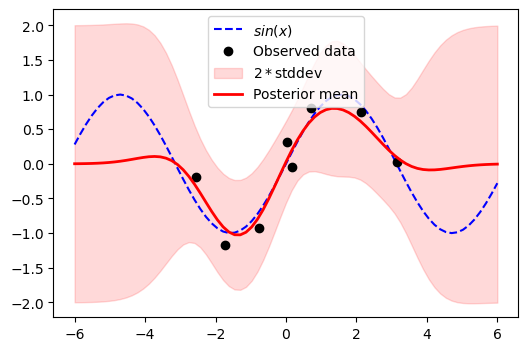

In [3]:
import scipy

def exponentiated_quadratic_kernel(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

# Gaussian process posterior
def GP_noise(x_train, y_train, x_test, sigma_noise, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    num_x_train = x_train.shape[0]
    K = kernel_func(x_train, x_train) + (sigma_noise**2) * np.eye(num_x_train)
    L = np.linalg.cholesky(K)
    m = np.linalg.solve(L, y_train)
    alpha = np.linalg.solve(L.T, m)

    # Kernel of observations vs to-predict
    K_s = kernel_func(x_train, x_test)
    mu = K_s.T @ alpha

    beta = np.linalg.solve(K, K_s)

    K_ss = kernel_func(x_test, x_test)
    cov = K_ss - K_s.T @ beta

    return mu, cov

# Compute posterior mean and covariance
sigma_noise = 0.5
y_train_noisy = y_train + ((sigma_noise ** 2) * np.random.randn(y_train.shape[0]))
mu_test, cov_test = GP_noise(x_train, y_train_noisy, x_test, sigma_noise, exponentiated_quadratic_kernel)
# Compute the standard deviation at the test points to be plotted
sigma_test = np.sqrt(np.diag(cov_test))

# Draw some samples of the posterior
y_test = np.random.multivariate_normal(mean=mu_test, cov=cov_test, size=ny)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(x_test, f_sin(x_test), 'b--', label='$sin(x)$')
ax.plot(x_train, y_train_noisy, 'ko', linewidth=2, label='Observed data')
ax.fill_between(x_test.flat, mu_test-2*sigma_test, mu_test+2*sigma_test, color='red', alpha=0.15, label=r'$2*\text{stddev}$')
ax.plot(x_test, mu_test, 'r-', lw=2, label=r'Posterior mean')
ax.legend()
plt.show()

Of note, we can see that the standard deviation of our predictions is no longer zero for our training data. Moreover,
we can see that our posterior mean no longer necessarily crosses through the training data points.

#### Choosing the kernel parameters

So far we've assumed a fixed kernel function $k(\cdot, \cdot)$. In practice, typically the kernel will have some hyperparameters
$\theta$ that we must specify. For example, the radial basis function kernel takes the form

$$ k(\mathbf{x}_p, \mathbf{x}_q) = \sigma^2_f \exp\left(-\frac{1}{2\ell^2}(\mathbf{x}_p -  \mathbf{x}_q)^2\right) $$

where our hyperparameters $\theta = \{\sigma^2_f, \ell\}$ are the signal variance $\sigma^2_f$ and the length-scale $\ell$. To emphasize
the dependence of a kernel on its hyperparameters, we may sometimes write $k_{\theta}(\cdot, \cdot)$ instead of just $k(\cdot, \cdot)$.
Note that, with our assumption of i.i.d. Gaussian noise we then have 

$$ cov(\mathbf{x}_p, \mathbf{x}_q) = \sigma^2_f \exp\left(-\frac{1}{2\ell^2}(\mathbf{x}_p -  \mathbf{x}_q)^2\right) + \delta_{pq}\sigma^2 $$

These parameters can have a _major impact_ on our final predictions. Thus, we need a systematic way to chose "good" values of
our hyperparameters. One way to do so is to set the parameters via maximum likelihood estimation, i.e., we choose the parameters
that maximize the likelihood $p(\mathbf{y} \mid X, \theta)$ of our observed training data given the corresponding inputs and
hyperparameters. Based on our assumptions in the previous subsection, we know

$$ \mathbf{y} \mid X, \theta \sim \mathcal{N}(\mathbf{0}, K_{\theta}(X, X) + \sigma_n^2I).$$

Thus, from the definition of the multivariate Gaussian distribution, we have

$$ p(\mathbf{y} \mid X, \theta) = -\frac{1}{2}\mathbf{y}^{T}(K_{\theta}(X, X) + \sigma_n^2I)^{-1}\mathbf{y} - \frac{1}{2}\left|K_{\theta}(X, X) + \sigma_n^2I\right| - \frac{n}{2}\log 2\pi.$$

We can then optimize $\theta$ (e.g. via gradient ascent) to maximize the above quantity.